# Reconhecimento de digitos usando MLP e CNN 

### Aprendizado de Máquina - Programa de Pós-Graduação em Automação e Sistemas - UFSC

### Professor Marcelo Ricardo Stemmer

### Alunos Andrei Donati e Angelo Baruffi 

**Reconhecimento de digitos (dataset MNIST) usando redes neurais comuns e redes neurais convulocionais no Keras**

As imagens estão disponíveis em www.kaggle.com/c/digit-recognizer/data e foram extraídas de um banco de dados da empresa de correios americana.
Depois de tratadas e regularizadas, as imagens foram disponibilizadas para uma competição no site Kaggle.com.

A apresentação fará a comparação de redes neurais para classificação dos digitos e utilizará a GPU para treinar a rede neural, melhorando o tempo de treinamento 

In [2]:
import tensorflow as tf
from keras import backend as K
import psutil

num_cores = psutil.cpu_count()
GPU= True

if GPU:
    num_GPU = 1
    num_CPU = 1
    print('Usando a GPU')
else:
    num_CPU = 1
    num_GPU = 0
    print('Usando apenas o CPU')

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
K.set_image_dim_ordering('th')
import time

Using TensorFlow backend.


Usando a GPU


## Dataset

Cada imagem tem 28 pixels de altura e 28 pixels de largura (784 pixels no total). Cada pixel tem um único valor (não é RGB, valor de 0 a 255), indicando a leveza ou a escuridão desse pixel.

O conjunto de dados de treino, possui 785 colunas. A primeira coluna, chamada "etiqueta", é o dígito que foi desenhado pelo usuário. O resto das colunas contém os valores de pixel da imagem associada.

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Exemplo de imagens

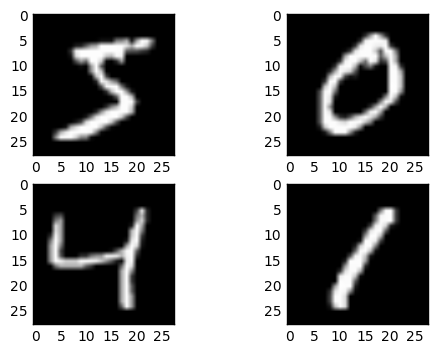

In [4]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))
plt.show()

Mais alguns exemplos de digitos
<img src="http://corochann.com/wp-content/uploads/2017/02/mnist_plot.png">

Define uma seed padrão para garantir reproducibilidade

In [4]:
seed = 7
np.random.seed(seed)

### Conceitos das redes neurais

As redes MLP que vamos construir são similares aquelas estudadas em sala.

**Todas as redes desenvolvidas aqui tem 10 neurônios de saída, correspondente aos 10 digitos a serem reconhecidos **
<img src="https://www.researchgate.net/profile/Isik_Yilmaz/publication/252625657/figure/fig1/AS:298156324605965@1448097415988/Fig-1-Multi-layer-perceptron-neural-network.png">

Vamos utilizar a função de ativação Relu para deixar a rede não linear. 
Esta função é <img src="https://ml4a.github.io/images/figures/relu.png">

Como vamos utilizar alguns parâmetros não explorados em sala, segue uma conceituação destes:

**nb_epoch:**
Quantidade de vezes que os dados serão passados adiante (forward pass) e retropropagados (backward pass) pela redes 

**batch_size:**
Número de exemplos de treinamento que serão passados em um forward/backward pass 

#### Uma breve visualização sobre as redes neurais convolucionais que vamos utilizar mais abaixo 

Uma rede neural convolucional é formada por algumas camadas diferentes das redes comuns. 

São as camadas **Convolutional**, **MaxPoolling** e **DropOut**. 
As imagens a seguir nos ajudam a visualizar estas camadas
<img src="https://www.mathworks.com/content/mathworks/www/en/discovery/convolutional-neural-network/jcr:content/mainParsys/image_copy.adapt.full.high.jpg/1497876372993.jpg">

Camada de DropOut

<img src="http://cs231n.github.io/assets/nn2/dropout.jpeg">

## MLP  Básica

Importação, reshape e tratamento do dataset 

In [29]:
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma MLP
Modelo com:
- uma camada com 800 neurônios com função Relu de ativação
- camada de saída com 10 neurônios

In [30]:
def mlp():
    model = Sequential()
    model.add(Dense(800, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, init='normal'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Executa o treinamento e o teste da rede neural

In [31]:
model = mlp()

start_time = time.time()

model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada em %.2f segundos" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
7s - loss: 0.2810 - acc: 0.9202 - val_loss: 0.1436 - val_acc: 0.9583
Epoch 2/10
5s - loss: 0.1105 - acc: 0.9685 - val_loss: 0.0977 - val_acc: 0.9706
Epoch 3/10
5s - loss: 0.0704 - acc: 0.9797 - val_loss: 0.0843 - val_acc: 0.9745
Epoch 4/10
5s - loss: 0.0493 - acc: 0.9859 - val_loss: 0.0773 - val_acc: 0.9766
Epoch 5/10
5s - loss: 0.0359 - acc: 0.9899 - val_loss: 0.0674 - val_acc: 0.9789
Epoch 6/10
5s - loss: 0.0255 - acc: 0.9932 - val_loss: 0.0618 - val_acc: 0.9803
Epoch 7/10
5s - loss: 0.0186 - acc: 0.9957 - val_loss: 0.0581 - val_acc: 0.9819
Epoch 8/10
7s - loss: 0.0139 - acc: 0.9971 - val_loss: 0.0714 - val_acc: 0.9795
Epoch 9/10
5s - loss: 0.0103 - acc: 0.9981 - val_loss: 0.0590 - val_acc: 0.9826
Epoch 10/10
5s - loss: 0.0073 - acc: 0.9989 - val_loss: 0.0616 - val_acc: 0.9818
Baseline Error: 1.82%
Rede treinada em 62.05 segundos


Encontra as imagens que ele classificou errado

In [32]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

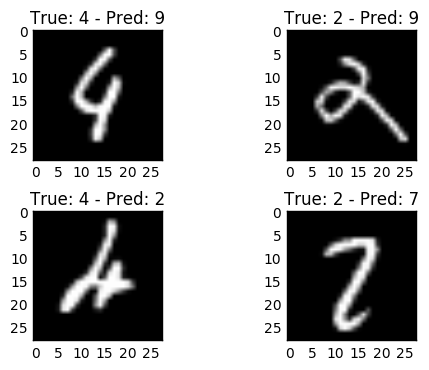

In [33]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Apesar de simples, a rede apresenta um desempenho bem interessante para o problema

## MLP Deep

Importação, reshape e tratamento do dataset

In [34]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma mlp deep.

Modelo com:
- uma camada com 800 neurônios com função Relu de ativação
- uma camada com 400 neurônios com função Relu de ativação
- camada de saída com 10 neurônios

In [35]:
def mlp_deep():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(800, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(400, input_dim=num_pixels, init='normal'))
    model.add(Activation('relu'))
    model.add(Dense(num_classes, init='normal'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Executa o treinamento e o teste da rede neural

In [36]:
model = mlp_deep()

start_time = time.time()

model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=15, batch_size=200, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada em %.2f segundos" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
11s - loss: 0.2151 - acc: 0.9352 - val_loss: 0.0936 - val_acc: 0.9708
Epoch 2/15
10s - loss: 0.0730 - acc: 0.9772 - val_loss: 0.0716 - val_acc: 0.9760
Epoch 3/15
10s - loss: 0.0481 - acc: 0.9845 - val_loss: 0.0715 - val_acc: 0.9767
Epoch 4/15
10s - loss: 0.0331 - acc: 0.9897 - val_loss: 0.0793 - val_acc: 0.9772
Epoch 5/15
10s - loss: 0.0253 - acc: 0.9918 - val_loss: 0.0759 - val_acc: 0.9789
Epoch 6/15
10s - loss: 0.0267 - acc: 0.9911 - val_loss: 0.0782 - val_acc: 0.9779
Epoch 7/15
10s - loss: 0.0165 - acc: 0.9945 - val_loss: 0.0854 - val_acc: 0.9789
Epoch 8/15
11s - loss: 0.0175 - acc: 0.9940 - val_loss: 0.0740 - val_acc: 0.9804
Epoch 9/15
11s - loss: 0.0184 - acc: 0.9936 - val_loss: 0.0954 - val_acc: 0.9776
Epoch 10/15
11s - loss: 0.0136 - acc: 0.9956 - val_loss: 0.0741 - val_acc: 0.9801
Epoch 11/15
10s - loss: 0.0133 - acc: 0.9959 - val_loss: 0.0819 - val_acc: 0.9801
Epoch 12/15
11s - loss: 0.0102 - acc: 0.9966 - val_loss: 

Encontra as imagens que ele classificou errado

In [37]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

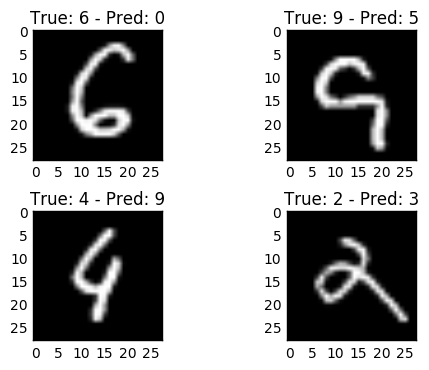

In [38]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Mesmo sendo mais complexa e demorada para treinar, tem um desempenho bem pior que a outra rede. A rede está apresentando overfitting, o que poderia ser utilizado um layer de dropout para ajudar

## CNN básica

Importação, reshape e tratamento do dataset

In [39]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma uma simples CNN.

Modelo com:
- uma camada de convolução de 32 filtros de 5x5
- uma camada de Pooling 2x2 com a função max()
- uma camada de DropOut de 20% dos neurônios
- uma camada com 128 neurônios com função Relu de ativação, estilo MLP
- camada de saída com 10 neurônios


In [40]:
def simple_ccn():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Executa o treinamento e o teste da rede neural

In [41]:
model = simple_ccn()

start_time = time.time()

model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=12, batch_size=200, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)

print("Baseline Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada em %.2f segundos" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
37s - loss: 0.2527 - acc: 0.9278 - val_loss: 0.0771 - val_acc: 0.9754
Epoch 2/12
35s - loss: 0.0753 - acc: 0.9776 - val_loss: 0.0505 - val_acc: 0.9846
Epoch 3/12
35s - loss: 0.0517 - acc: 0.9842 - val_loss: 0.0441 - val_acc: 0.9862
Epoch 4/12
35s - loss: 0.0397 - acc: 0.9874 - val_loss: 0.0362 - val_acc: 0.9885
Epoch 5/12
35s - loss: 0.0316 - acc: 0.9905 - val_loss: 0.0343 - val_acc: 0.9883
Epoch 6/12
36s - loss: 0.0268 - acc: 0.9914 - val_loss: 0.0309 - val_acc: 0.9893
Epoch 7/12
36s - loss: 0.0213 - acc: 0.9933 - val_loss: 0.0322 - val_acc: 0.9885
Epoch 8/12
36s - loss: 0.0191 - acc: 0.9941 - val_loss: 0.0340 - val_acc: 0.9886
Epoch 9/12
36s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.0272 - val_acc: 0.9909
Epoch 10/12
35s - loss: 0.0142 - acc: 0.9952 - val_loss: 0.0344 - val_acc: 0.9895
Epoch 11/12
36s - loss: 0.0109 - acc: 0.9964 - val_loss: 0.0320 - val_acc: 0.9895
Epoch 12/12
36s - loss: 0.0106 - acc: 0.9964 - val_loss: 

Encontra as imagens que ele classificou errado

In [42]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

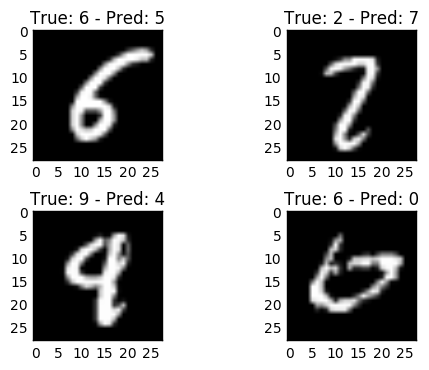

In [43]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Rede que apresenta um desempenho muito bom, como o esperado para redes CNNs, porém tem grande tempo de treinamento

## CNN Larger

Importação, reshape e tratamento do dataset

In [44]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

X_train = X_train / 255
X_test = X_test / 255

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#### Construção do modelo de uma uma simples CNN.

Modelo com:
- uma camada de convolução de 32 filtros de 5x5
- uma camada de Pooling 2x2 com a função max()
- uma camada de DropOut de 20% dos neurônios
- uma camada de convolução de 15 filtros de 3x3
- uma camada de Pooling 2x2 com a função max()
- uma camada de DropOut de 20% dos neurônios
- uma camada com 128 neurônios com função Relu de ativação, estilo MLP
- uma camada com 50 neurônios com função Relu de ativação, estilo MLP
- camada de saída com 10 neurônios

In [45]:
def cnn_larger():
    model = Sequential()
    model.add(Convolution2D(32, 5, 5, input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(15, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [46]:
model = cnn_larger()

start_time = time.time()

model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=10, batch_size=200)
scores = model.evaluate(X_test, y_test, verbose=0)

print("Large CNN Error: %.2f%%" % (100-scores[1]*100))
print("Rede treinada em %.2f segundos" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 40s - loss: 0.3781 - acc: 0.8819 - val_loss: 0.0751 - val_acc: 0.9756
Epoch 2/10
60000/60000 [==============================] - 40s - loss: 0.0922 - acc: 0.9722 - val_loss: 0.0510 - val_acc: 0.9844
Epoch 3/10
60000/60000 [==============================] - 38s - loss: 0.0662 - acc: 0.9795 - val_loss: 0.0414 - val_acc: 0.9869
Epoch 4/10
60000/60000 [==============================] - 38s - loss: 0.0549 - acc: 0.9828 - val_loss: 0.0369 - val_acc: 0.9882
Epoch 5/10
60000/60000 [==============================] - 37s - loss: 0.0460 - acc: 0.9858 - val_loss: 0.0292 - val_acc: 0.9908
Epoch 6/10
60000/60000 [==============================] - 38s - loss: 0.0411 - acc: 0.9870 - val_loss: 0.0309 - val_acc: 0.9898
Epoch 7/10
60000/60000 [==============================] - 40s - loss: 0.0361 - acc: 0.9886 - val_loss: 0.0266 - val_acc: 0.9919
Epoch 8/10
60000/60000 [==============================

Encontra as imagens que ele classificou errado

In [47]:
pred = model.predict(X_test, verbose=0)
pred = np.argmax(pred, axis=1)
labels = np.argmax(y_test, axis=1)
wrong_class = [i for i in range(pred.size) if pred[i]!=labels[i]]

(X_train, y_train), (X_test, y_test) = mnist.load_data()

Plot das imagens que ele classificou errado

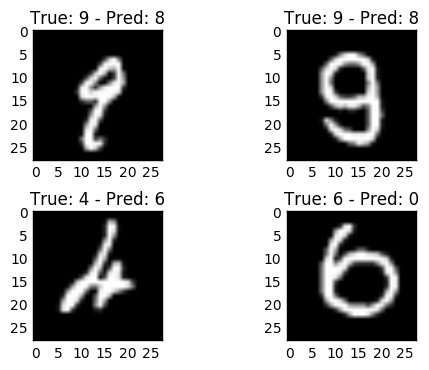

In [24]:
plt.subplot(221).set_title("True: "+ str(labels[wrong_class[0]])+ " - Pred: " + str(pred[wrong_class[0]]) )
plt.imshow(X_test[wrong_class[0]], cmap=plt.get_cmap('gray'))
plt.subplot(222).set_title("True: "+ str(labels[wrong_class[1]])+ " - Pred: " + str(pred[wrong_class[1]]) )
plt.imshow(X_test[wrong_class[1]], cmap=plt.get_cmap('gray'))
plt.subplot(223).set_title("True: "+ str(labels[wrong_class[2]])+ " - Pred: " + str(pred[wrong_class[2]]) )
plt.imshow(X_test[wrong_class[2]], cmap=plt.get_cmap('gray'))
plt.subplot(224).set_title("True: "+ str(labels[wrong_class[3]])+ " - Pred: " + str(pred[wrong_class[3]]) )
plt.imshow(X_test[wrong_class[3]], cmap=plt.get_cmap('gray'))
plt.subplots_adjust(hspace=0.4)
plt.show()

#### Conclusão sobre o modelo: 
Rede com desempenho muito bom (próximo do Estado da Arte), porém com altíssima necessidade de desempenho computacional

## Código disponível em 

## Referências

www.kaggle.com/c/digit-recognizer - Acessado em 24 de setembro de 2017

machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/ - Acessado em 24 de setembro de 2017
